In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/Kannada-MNIST/sample_submission.csv
/kaggle/input/Kannada-MNIST/Dig-MNIST.csv
/kaggle/input/Kannada-MNIST/train.csv
/kaggle/input/Kannada-MNIST/test.csv


In [7]:
import torch.nn as nn
import torch
import matplotlib.pyplot as plt
from torchvision import datasets,transforms
from torchvision.transforms import ToTensor
import torch.optim as optim
import torch.nn.functional as F
import os
from torch.utils.data import DataLoader,Dataset
from torchvision.io import read_image
import pandas as pd
import numpy as np

In [4]:
training_data = pd.read_csv("/kaggle/input/Kannada-MNIST/train.csv")
test_data = pd.read_csv("/kaggle/input/Kannada-MNIST/test.csv")
valid_data = pd.read_csv("/kaggle/input/Kannada-MNIST/Dig-MNIST.csv")

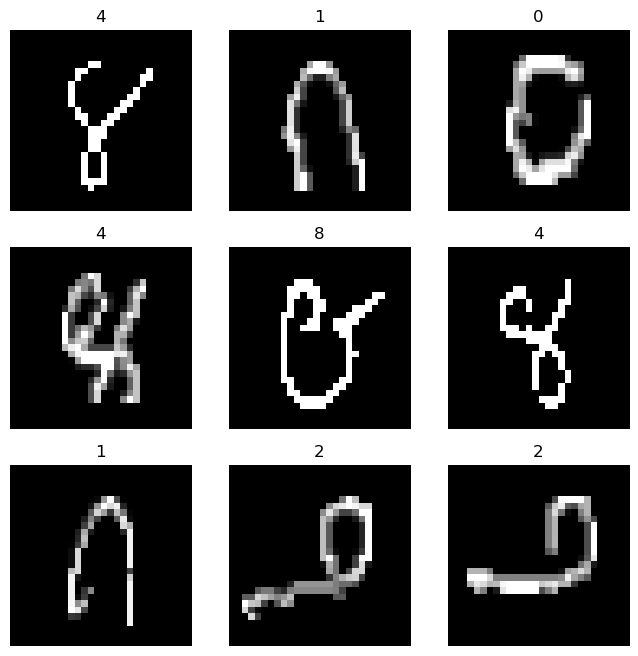

In [5]:
import matplotlib.pyplot as plt
labels_map = {
    0: "0",
    1: "1",
    2: "2",
    3: "3",
    4: "4",
    5: "5",
    6: "6",
    7: "7",
    8: "8",
    9: "9",
}
figure = plt.figure(figsize = (8,8))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):

    # taking a random index in the range 0 to length of training_data
    sample_idx = torch.randint(len(training_data), size = (1,)).item()

    # training_data[i] returns image and the label of the image.
    labels = training_data.iloc[sample_idx,0]
    img = np.array(training_data.drop("label", axis = 1).iloc[sample_idx].values).reshape((28,28))

    # Visualizing the images
    figure.add_subplot(rows, cols, i)
    plt.title(labels)
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap = "gray")
plt.show()

In [8]:
class KanadaMNIST(Dataset):
    def __init__(self,csv,transform=None,target_transform=None):
        self.data=pd.read_csv(csv)
        self.img_labels=self.data.iloc[:,0]
        self.img=self.data.iloc[:,1:]
        self.transform=transform
        self.target=target_transform

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self,idx):
        image=self.img.iloc[idx,:].values.reshape(28,28)
        #image=pixel_val.reshape((28,28))
        label=self.img_labels.iloc[idx]
        if self.transform:
            image=self.transform(image)
        if self.target:
            label=self.target(label)
        return image,label

In [9]:
train=KanadaMNIST("/kaggle/input/Kannada-MNIST/train.csv")
test=KanadaMNIST("/kaggle/input/Kannada-MNIST/test.csv")
val=KanadaMNIST("/kaggle/input/Kannada-MNIST/Dig-MNIST.csv")

In [10]:
batch_size=64
train_data=DataLoader(train,batch_size=batch_size,shuffle=True)
test_data=DataLoader(test,batch_size=batch_size,shuffle=True)
val_data=DataLoader(val,batch_size=batch_size,shuffle=True)

Feature batch shape: torch.Size([64, 28, 28])
Labels batch shape: torch.Size([64])


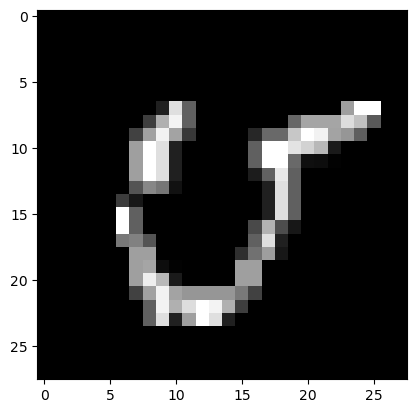

Label: 8


In [11]:
import matplotlib.pyplot as plt

train_features, train_labels = next(iter(train_data))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")

# Reshape the feature tensor to 2D (28x28)
img = np.array(train_features[0].reshape(28, 28))

label = train_labels[0].item()  # Convert tensor to Python scalar
plt.imshow(img, cmap="gray")
plt.show()
print(f"Label: {label}")

In [12]:
from torch.utils.data import DataLoader

train_dataloader = DataLoader(training_data, batch_size = 64, shuffle = True)
test_dataloader = DataLoader(test_data, batch_size = 64, shuffle = False)
valid_dataloader = DataLoader(valid_data, batch_size = 64, shuffle = False)

In [16]:
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork,self).__init__()
        self.flatten=nn.Flatten()
        self.fc1=nn.Linear(28*28,512)
        self.relu=nn.ReLU()
        self.fc2=nn.Linear(512,512)
        self.fc3=nn.Linear(512,10)
        self.softmax=nn.Softmax(dim=1)
    def forward(self,x):
        x = x.float()
        x = self.flatten(x)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.relu(x)
        x = self.fc3(x)
        x = self.softmax(x)
        return x
    
model=NeuralNetwork()
model

NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=784, out_features=512, bias=True)
  (relu): ReLU()
  (fc2): Linear(in_features=512, out_features=512, bias=True)
  (fc3): Linear(in_features=512, out_features=10, bias=True)
  (softmax): Softmax(dim=1)
)

In [17]:
learning_rate=0.01
batch_size=64
num_epochs=10

loss = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(),lr=learning_rate)

In [22]:
from sklearn.metrics import accuracy_score

def train_model(model, dataloader, optmizer, loss_fn):
    model.train()
    train_loss, train_acc= 0, 0

    for X, y in dataloader:
        # Forward Pass
        X, y = X.to(torch.device("cpu")), y.to(torch.device("cpu"))
        y_pred = model(X)
        loss = loss_fn(y_pred, y)

        train_loss += loss
        train_acc += accuracy_score(y.cpu(), y_pred.cpu().argmax(dim= 1))

        # Back Propagation
        optmizer.zero_grad()
        loss.backward()
        optmizer.step()

        train_loss /= len(dataloader)

    train_acc /= len(dataloader)
    print(f"Train loss: {train_loss:.4f} | Train accuracy: {train_acc:.4f}")   

In [26]:
def val_model(model, dataloader, optmizer, loss_fn):
    model.eval()
    val_loss, val_acc= 0, 0

    with torch.inference_mode():
        for X, y in dataloader:
            X, y = X.to(torch.device("cpu")), y.to(torch.device("cpu"))
            y_pred = model(X)

            val_loss += loss_fn(y_pred, y)
            val_acc += accuracy_score(y.cpu(), y_pred.cpu().argmax(dim= 1))

            val_loss /= len(dataloader)
        val_acc /= len(dataloader)
        print(f"Val loss: {val_loss:.4f}     | Val accuracy: {val_acc:.4f}")

In [27]:
def test_loop(model, dataloader, optmizer, loss_fn):
    model.eval()
    val_loss, val_acc= 0, 0

    with torch.inference_mode():
        for X, y in dataloader:
            X, y = X.to(torch.device("cpu")), y.to(torch.device("cpu"))
            y_pred = model(X)

            val_loss += loss_fn(y_pred, y)
            val_acc += accuracy_score(y.cpu(), y_pred.cpu().argmax(dim= 1))

            val_loss /= len(dataloader)
        val_acc /= len(dataloader)
        print(f"test loss: {val_loss:.4f}     | test accuracy: {val_acc:.4f}")

In [28]:
lr = 1e-4
loss_fn = nn.CrossEntropyLoss()
optmizer= torch.optim.Adam(model.parameters(), lr= lr)

for epoch in range(num_epochs):
    print(f"epoch: {epoch}")
    print("--------------------------------------------------------")
    train_model(model, train_data, optmizer, loss_fn)
    val_model(model, val_data, optmizer, loss_fn)
    #test_loop(model,test_data,optimizer,loss_fn)

epoch: 0
--------------------------------------------------------
Train loss: 0.0016 | Train accuracy: 0.8907
Val loss: 0.0107     | Val accuracy: 0.6046
epoch: 1
--------------------------------------------------------
Train loss: 0.0016 | Train accuracy: 0.9745
Val loss: 0.0116     | Val accuracy: 0.6037
epoch: 2
--------------------------------------------------------
Train loss: 0.0016 | Train accuracy: 0.9808
Val loss: 0.0123     | Val accuracy: 0.5976
epoch: 3
--------------------------------------------------------
Train loss: 0.0016 | Train accuracy: 0.9843
Val loss: 0.0109     | Val accuracy: 0.6453
epoch: 4
--------------------------------------------------------
Train loss: 0.0016 | Train accuracy: 0.9865
Val loss: 0.0120     | Val accuracy: 0.6485
epoch: 5
--------------------------------------------------------
Train loss: 0.0016 | Train accuracy: 0.9879
Val loss: 0.0111     | Val accuracy: 0.6249
epoch: 6
--------------------------------------------------------
Train loss